In [1]:
import numpy as np
import pandas as pd
import ast
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from scipy.stats import norm
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#!pip install pydot
import pydot
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import RobustScaler

Using TensorFlow backend.


In [2]:
# 현재 데이터 셋 불러오기
total_data = pd.read_csv('data_873.csv')

In [3]:
display(total_data.head())
print(len(total_data))

,id,type,payload,created_at,status,creator_id,inspector,project_id,schedule_state,reliability,inspector_count
0,7acb1948-a5f6-41f1-8010-d336c6e91d23,image,"{""meta"": {""crop_image"": [{""correct"": [1], ""sha...",2019-10-13T08:41:57+09:00,done,b1af665e-b6f9-4b17-82fd-cc5c5421a632,{b1af665e-b6f9-4b17-82fd-cc5c5421a632},4ff5f94d-694d-420e-b7d6-0ccad18eb1f1,queued,0,1
1,0b17d0c0-4231-4796-862e-d0791576ee7d,image,"{""meta"": {""crop_image"": [{""correct"": [1], ""sha...",2019-10-13T09:14:00+09:00,done,c2cf64b2-8534-4ab5-a883-a1d3410afdba,{c2cf64b2-8534-4ab5-a883-a1d3410afdba},4ff5f94d-694d-420e-b7d6-0ccad18eb1f1,queued,0,1
2,4490fe3e-0c28-4e55-adbe-e79d10ec429e,image,"{""meta"": {""crop_image"": [{""correct"": [1], ""sha...",2019-10-13T09:22:24+09:00,done,d65f0a4e-7815-4194-a347-2ad0f7841f74,{b1af665e-b6f9-4b17-82fd-cc5c5421a632},4ff5f94d-694d-420e-b7d6-0ccad18eb1f1,queued,0,1
3,a21c58ce-2539-40fd-9624-c1182dc07b95,image,"{""meta"": {""crop_image"": [{""correct"": [1], ""sha...",2019-10-13T09:23:53+09:00,done,bd88f55c-4046-41ad-8b63-70b6a9e25121,{b1af665e-b6f9-4b17-82fd-cc5c5421a632},4ff5f94d-694d-420e-b7d6-0ccad18eb1f1,queued,0,1
4,3ddbbb93-8127-4801-b90e-3eacc139e6d4,image,"{""meta"": {""crop_image"": [{""correct"": [0], ""sha...",2019-10-13T09:25:36+09:00,failure,bd88f55c-4046-41ad-8b63-70b6a9e25121,{5d4b121c-d331-4c64-8811-524a38e3e31b},4ff5f94d-694d-420e-b7d6-0ccad18eb1f1,queued,0,1


873


# EDA

## Feature로 활용할 데이터 추출
위 데이터 프레임에서 feature로 활용할 데이터를 추출해낸다

### Feature1 - Compare size
`compare_size` - 데이터 생산자가 crop 한 영역의 총합을 AI 어시스턴트가 Detection 한 영역의 총합으로 나눈 값

In [4]:
# 각 데이터의 compare_size 를 compare_size 컬럼에 추가한다
total_data['compare_size'] = total_data.apply(lambda row: json.loads(row['payload'])['meta']['compare_size'], axis=1)
#display(total_data.head())

### Feature2 - image_time
`image_time` - 데이터 생산자가 작업(가공) 할 이미지를 작업 페이지에 올린 시간으로부터 최종 제출 까지 걸린 시간

In [5]:
# 각 데이터의 image_time 을 image_time 컬럼에 추가한다
total_data['image_time'] = total_data.apply(lambda row: json.loads(row['payload'])['meta']['crop_image'][0]['region_attributes']['image_time'], axis=1)
#display(total_data.head())

### Feature3 - recognition_prob_avg
`recognition_prob_avg` - 데이터 생산자가 crop 한 각 텍스트 영역들을 AI 어시스턴트가 Recognition 한 결과로 나온 confident 값들의 평균값

In [6]:
# 각 데이터의 각 crop 이미지에 대해 recognition 정확도의 평균값을 recognition_avg 컬럼에 추가한다
recognition_prob_metric = 'avg'
# recognition_prob_metric = 'min'

total_data['recognition_prob'] = total_data.apply(lambda row: [float(json.loads(row['payload'])['meta']['crop_image'][i]['region_attributes']['prob']) for i in range(len(json.loads(row['payload'])['meta']['crop_image'])) ], axis=1)
if recognition_prob_metric == 'avg':
    total_data['recognition_prob_avg'] = total_data.apply(lambda row: sum(row['recognition_prob']) / len(row['recognition_prob']), axis=1)
# elif recognition_prob_metric == 'min':
#     total_data['recognition_prob_avg'] = total_data.apply(lambda row: min(row['recognition_prob']), axis=1)

#display(total_data.head())

### Feature4 - similarity_avg
`similarity_avg` - 데이터 생산자가 crop한 각 텍스트 영역들에 labeling 한 string과 AI 어시스턴트가 각 영역을 Recognition한 결과로 나온 string의 유사도

In [7]:
# 각 데이터의 각 crop 이미지의 label 값에 대해 similarity의 평균값을 similarity_avg 컬럼에 추가한다
recognition_prob_metric = 'avg'
# recognition_prob_metric = 'min'

total_data['similarity'] = total_data.apply(lambda row: [float(json.loads(row['payload'])['meta']['crop_image'][i]['region_attributes']['similarity']) for i in range(len(json.loads(row['payload'])['meta']['crop_image'])) ], axis=1)
if recognition_prob_metric == 'avg':
    total_data['similarity_avg'] = total_data.apply(lambda row: sum(row['similarity']) / len(row['similarity']), axis=1)
# elif recognition_prob_metric == 'min':
#         total_data['similarity_avg'] = total_data.apply(lambda row: min(row['similarity']), axis=1)

#display(total_data.head())

## 데이터 탐색

### feature, label 추출
feature 컬럼과 label 컬럼을 추출합니다

In [8]:
# 전체 데이터 중에서 의미 있다고 여겨지는 항목만 가져오기
data = total_data[['compare_size', 'image_time', 'recognition_prob_avg', 'similarity_avg', 'status']]
display(data.head())

,compare_size,image_time,recognition_prob_avg,similarity_avg,status
0,1.053141,183500,0.889338,0.912753,done
1,0.683934,143721,0.744380,0.995392,done
2,1.008688,168192,0.936881,0.917415,done
3,0.381340,69765,0.986547,0.739130,done
4,0.320067,81555,0.898564,0.537415,failure


### 정상 데이터와 비정상 데이터 수 비교

In [9]:
# done된 데이터와 fail된 데이터 합치기
print("done:", len(data[data['status'] == 'done']))
print("fail:", len(data[data['status'] == 'failure']))

done: 505
fail: 368


### status 컬럼 값을 numeric하게 변경
감지하려고 하는 데이터는 반려, 즉 'failure' 된 데이터 이므로 해당 값 1로, 정상 데이터를 0으로 numeric하게 변환한다

In [10]:
#데이터 항목 중 status를 0과 1로 변경
data['status'] = data.apply(lambda row: 1 if row['status'] == "failure" else 0, axis=1)
display(data.head())

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,compare_size,image_time,recognition_prob_avg,similarity_avg,status
0,1.053141,183500,0.889338,0.912753,0
1,0.683934,143721,0.744380,0.995392,0
2,1.008688,168192,0.936881,0.917415,0
3,0.381340,69765,0.986547,0.739130,0
4,0.320067,81555,0.898564,0.537415,1


### Null 값 확인
Null인 값이 들어간 feature는 없는 것으로 확인됨

In [11]:
data.isnull().sum()

compare_size            0
image_time              0
recognition_prob_avg    0
similarity_avg          0
status                  0
dtype: int64

### 각 feature별 히스토그램 생성
각 feature별로 데이터의 분포를 파악하기 위해 히스토그램을 그려본다

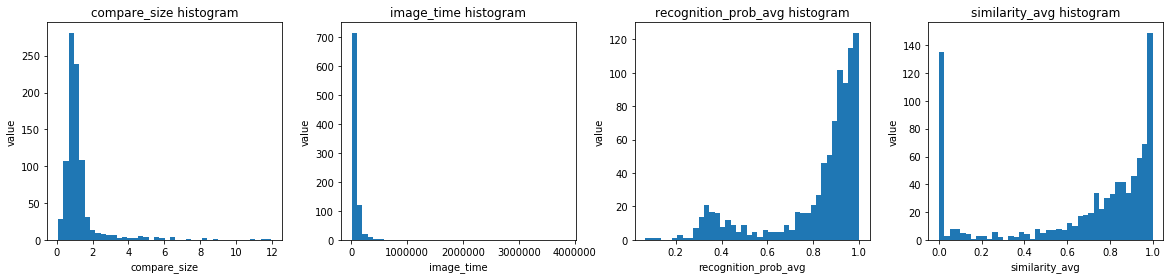

In [12]:
# compare_size 를 시각화한다
def draw_feature_histogram(dataset):
    plt.figure(figsize=(20, 4))
    
    for column, i in zip(dataset.columns, range(len(dataset.columns))):
        # compare_size 히스토그램
        plt.subplot(1, len(dataset.columns), i+1)
        plt.hist(dataset[column], bins=40)
        plt.xlabel(column)
        plt.ylabel('value')
        plt.title(f'{column} histogram')
        plt.subplots_adjust(wspace=0.25)

    # 마진 조정
    plt.show()
    
draw_feature_histogram(data[['compare_size', 'image_time', 'recognition_prob_avg', 'similarity_avg']])

## 데이터 정제
각 feature별 히스토그램을 그려보니 몇몇 feature에서 이상치가 존재하는 것 같다. 이러한 이상치의 분포를 파악하고 이를 제거해보자

### Box plot
데이터의 이상치가 어떻게 존재하는지 확인하기 위해 각 feature별로 boxplot을 그려보도록 하자

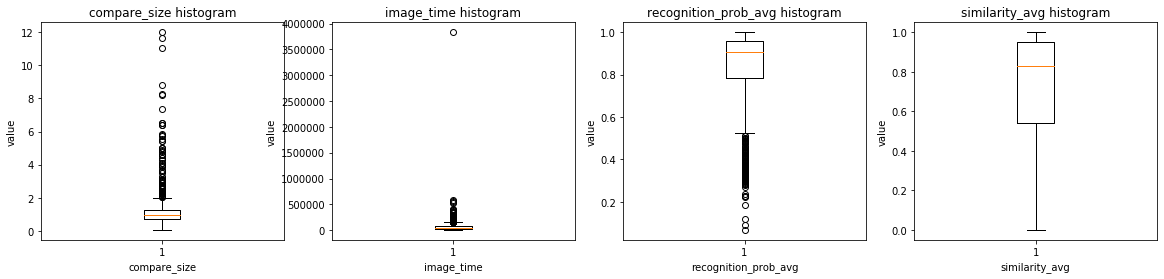

In [13]:
def draw_feature_boxplot(dataset):    
    plt.figure(figsize=(20, 4))

    for column, i in zip(dataset.columns, range(len(dataset.columns))):
        # compare_size 히스토그램
        plt.subplot(1, len(dataset.columns), i+1)
        plt.boxplot(dataset[column])
        plt.xlabel(column)
        plt.ylabel('value')
        plt.title(f'{column} histogram')

    plt.show()

draw_feature_boxplot(data[['compare_size', 'image_time', 'recognition_prob_avg', 'similarity_avg']])

### 이상치 제거
`recognition feature`는 0과 1사이의 값이 나와야 하므로 0.5 밑의 값이 이상치라 판단하기 힘들지만, `compare_size`와 `image_time` feature의 경우 범주가 정해진 값이 아니기에 이상치를 제거해준다

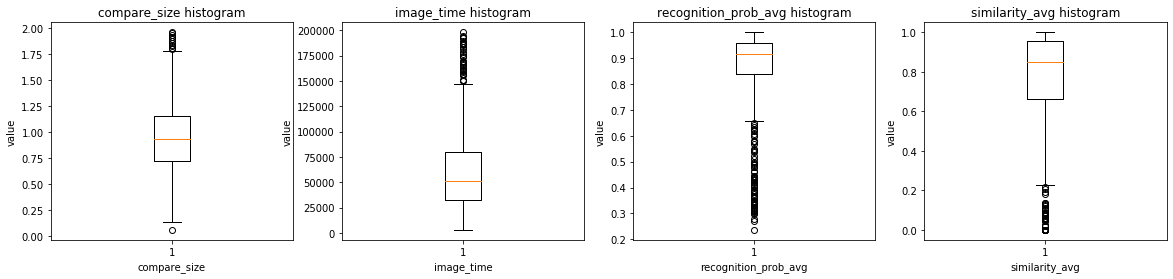

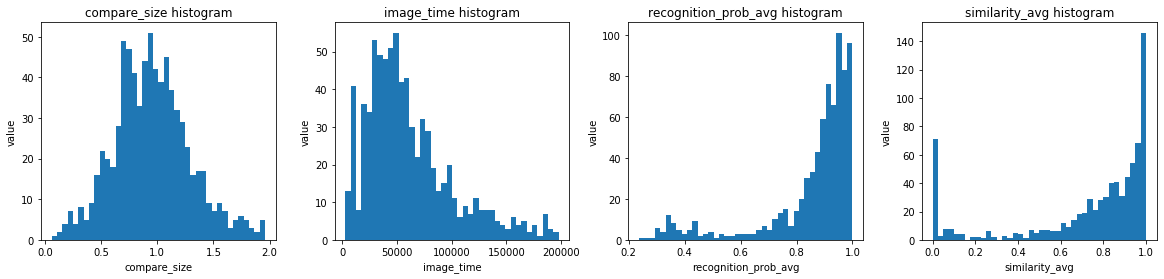

done: 481
fail: 286


In [14]:
# image_time이 긴, compare_size가 큰(이상치) 데이터 제거
data = data[data["image_time"] < 200000]
data = data[data["compare_size"] < 2]
draw_feature_boxplot(data[['compare_size', 'image_time', 'recognition_prob_avg', 'similarity_avg']])
draw_feature_histogram(data[['compare_size', 'image_time', 'recognition_prob_avg', 'similarity_avg']])

# done된 데이터와 fail된 데이터 수 비교
print("done:", len(data[data['status'] == 0]))
print("fail:", len(data[data['status'] == 1]))

# Feature Engineering(상관분석)
feature간의 상관 분석을 통해서 다중 공선성 문제가 존재하는지 파악한다.

In [15]:
# # 산점도 및 histogram
# sns.pairplot(data, diag_kind='kde', hue='status', palette='bright')
# plt.show()

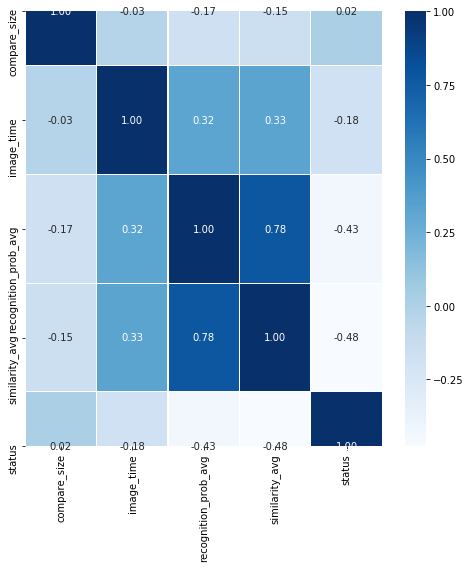

In [17]:
# 히트맵 그리기
plt.figure(figsize=(8,8))
cor = data.corr()
sns.heatmap(data=cor, annot=True, 
fmt = '.2f', linewidths=.1, cmap='Blues')

`recognition_prob_avg` 와 `similarity_avg` 두 feature간에 강한 상관관계(0.77)이 존재한다고 밝혀졌다. 두 변수 모두 종속변수(`state`)에 영향을 미치는 정도가 비슷(`-0.43`, `-0.49`)하므로 더 설명하기가 좋은 `similarity_avg` feature를 남겨두고 `recognition_prob_avg` feature를 제거하도록 하자

In [18]:
# 전체 데이터 중에서 의미 있다고 여겨지는 항목만 가져오기
data = data[['compare_size', 'image_time', 'similarity_avg', 'status']]
# data = data[['compare_size', 'image_time', 'recognition_prob_avg', 'similarity_avg', 'status']]
display(data.head())

,compare_size,image_time,similarity_avg,status
0,1.053141,183500,0.912753,0
1,0.683934,143721,0.995392,0
2,1.008688,168192,0.917415,0
3,0.381340,69765,0.739130,0
4,0.320067,81555,0.537415,1


# 모델 생성 및 성능 평가
주어진 feature들을 활용하여 classification model을 만들고, model이 성능을 측정하여 가장 높은 성능을 드러낼 때 활용되는 feature는 무엇인지 탐색한다

## feature 및 labels 분리
데이터셋에서 feature와 label로 활용할 column을 추출한다

In [19]:
# 데이터셋을 feature와 label로 분리
features = data[['compare_size', 'image_time', 'similarity_avg']]
# data = data[['compare_size', 'image_time', 'recognition_prob_avg', 'similarity_avg', 'status']]
labels = data[['status']]
# display(features.head())
# display(labels.head())

## train/test split
데이터를 train set과 test set으로 `7:3`의 비율로 분리한다

In [20]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3)

## 스케일링
feature의 값들을 정규화 해준다

In [21]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Logistic Regression 모델 생성

In [22]:
LR_model = LogisticRegression()
LR_model.fit(x_train_scaled, y_train)
y_pred = LR_model.predict(x_test_scaled)
y_prob = LR_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

총 테스트 개수: 231, 오류 개수: 57
Accuracy(정확도) : 0.7532467532467533
Recall(재현율) : 0.8571428571428571
Precision(정밀도) : 0.45652173913043476
F1 score: 0.5957446808510638
training set R2 결정 계수 : 0.7574626865671642
test set R2 결정 계수 : 0.7532467532467533


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## KNN 모델 생성

In [23]:
KNN_model = KNeighborsClassifier(n_neighbors=10)
KNN_model.fit(x_train_scaled, y_train)
y_pred = KNN_model.predict(x_test_scaled)
y_prob = KNN_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

총 테스트 개수: 231, 오류 개수: 60
Accuracy(정확도) : 0.7402597402597403
Recall(재현율) : 0.82
Precision(정밀도) : 0.44565217391304346
F1 score: 0.5774647887323944
training set R2 결정 계수 : 0.7574626865671642
test set R2 결정 계수 : 0.7532467532467533


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


## SVM 모델 생성

In [24]:
SVC_model = SVC(probability=True)
SVC_model.fit(x_train_scaled, y_train)
y_pred = SVC_model.predict(x_test_scaled)
y_prob = SVC_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

총 테스트 개수: 231, 오류 개수: 56
Accuracy(정확도) : 0.7575757575757576
Recall(재현율) : 0.9285714285714286
Precision(정밀도) : 0.42391304347826086
F1 score: 0.582089552238806
training set R2 결정 계수 : 0.7574626865671642
test set R2 결정 계수 : 0.7532467532467533


C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## Decision Tree 모델 생성

In [25]:
DT_model = DecisionTreeClassifier()
DT_model.fit(x_train_scaled, y_train)
y_pred = DT_model.predict(x_test_scaled)
y_prob = DT_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

총 테스트 개수: 231, 오류 개수: 67
Accuracy(정확도) : 0.70995670995671
Recall(재현율) : 0.6344086021505376
Precision(정밀도) : 0.6413043478260869
F1 score: 0.6378378378378379
training set R2 결정 계수 : 0.7574626865671642
test set R2 결정 계수 : 0.7532467532467533


## 랜덤 포레스트 모델 생성

In [26]:
RF_model = RandomForestClassifier()
RF_model.fit(x_train_scaled, y_train)
y_pred = RF_model.predict(x_test_scaled)
y_prob = RF_model.predict_proba(x_test_scaled)

print("총 테스트 개수: {}, 오류 개수: {}".format(len(y_pred), (y_pred != y_test.status).sum()))
print("Accuracy(정확도) : {}".format(accuracy_score(y_pred, y_test)))
print("Recall(재현율) : {}".format(recall_score(y_pred, y_test)))
print("Precision(정밀도) : {}".format(precision_score(y_pred, y_test)))
print("F1 score: {}".format(f1_score(y_pred, y_test)))
print('training set R2 결정 계수 : {}'.format(LR_model.score(x_train_scaled, y_train)))
print('test set R2 결정 계수 : {}'.format(LR_model.score(x_test_scaled, y_test)))

총 테스트 개수: 231, 오류 개수: 65
Accuracy(정확도) : 0.7186147186147186
Recall(재현율) : 0.7076923076923077
Precision(정밀도) : 0.5
F1 score: 0.5859872611464968
training set R2 결정 계수 : 0.7574626865671642
test set R2 결정 계수 : 0.7532467532467533


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


## Simple Neural Net

In [27]:
# 모델 정의
NN_model = Sequential([
    Dense(32, input_shape=(3,)),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(12),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid'),
])
# 컴파일
NN_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Training
NN_model.fit(x_train_scaled, y_train, epochs=120, batch_size=16)
# test
preds = NN_model.evaluate(x=x_test_scaled, y=y_test)
y_prob = NN_model.predict_proba(x_test_scaled)

print(preds)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/120
536/536 [==============================] - 0s 644us/step - loss: 0.6590 - accuracy: 0.6306
Epoch 2/120
536/536 [==============================] - 0s 149us/step - loss: 0.5906 - accuracy: 0.7295
Epoch 3/120
536/536 [==============================] - 0s 143us/step - loss: 0.5567 - accuracy: 0.7388
Epoch 4/120
536/536 [==============================] - 0s 127us/step - loss: 0.5413 - accuracy: 0.7556
Epoch 5/120
536/536 [==============================] - 0s 119us/step - loss: 0.5317 - accuracy: 0.7593
Epoch 6/120
536/536 [==============================] - 0s 130us/step - loss: 0.5240 - accuracy: 0.7519
Epoch 7/120
536/536 [==============================] - 0s 127us/step - loss: 0.5174 - accuracy: 0.7593
Epoch 8/120
536/536 [==============================] - 0s 121us/step - loss: 0.5071 - accuracy: 0.7593


536/536 [==============================] - 0s 151us/step - loss: 0.4165 - accuracy: 0.8060
Epoch 72/120
536/536 [==============================] - 0s 188us/step - loss: 0.4173 - accuracy: 0.8134
Epoch 73/120
536/536 [==============================] - 0s 169us/step - loss: 0.4146 - accuracy: 0.8097
Epoch 74/120
536/536 [==============================] - 0s 147us/step - loss: 0.4101 - accuracy: 0.8153
Epoch 75/120
536/536 [==============================] - 0s 131us/step - loss: 0.4141 - accuracy: 0.8134
Epoch 76/120
536/536 [==============================] - 0s 139us/step - loss: 0.4099 - accuracy: 0.8172
Epoch 77/120
536/536 [==============================] - 0s 140us/step - loss: 0.4100 - accuracy: 0.8097
Epoch 78/120
536/536 [==============================] - 0s 128us/step - loss: 0.4106 - accuracy: 0.8190
Epoch 79/120
536/536 [==============================] - 0s 138us/step - loss: 0.4130 - accuracy: 0.8041
Epoch 80/120
536/536 [==============================] - 0s 141us/step - loss:

### 모델별 ROC 커브 및 AUC 확인

In [28]:
from sklearn.metrics import roc_curve, auc

def draw_roc_curve(model, name):
    y_prob = model.predict_proba(x_test_scaled)
    
    false_positive_rate = 0
    true_positive_rate = 0
    thresholds = 0
    if name == 'Neural Net':
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob.T[0])
    else:
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob.T[1])
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.plot(false_positive_rate, true_positive_rate, label=f'{name} = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

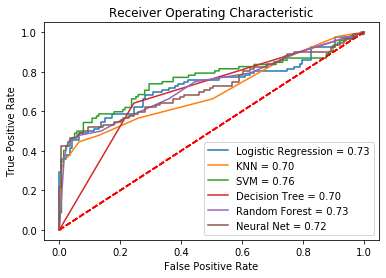

In [29]:
draw_roc_curve(LR_model, 'Logistic Regression')
draw_roc_curve(KNN_model, 'KNN')
draw_roc_curve(SVC_model, 'SVM')
draw_roc_curve(DT_model, 'Decision Tree')
draw_roc_curve(RF_model, 'Random Forest')
draw_roc_curve(NN_model, 'Neural Net')

# 여기까지가 이미지 데이터 신뢰도 예측 모델의 구현 과정
모델의 성능 저조 원인?
- 적은 feature 수
- `avg` 라는 대표값을 feature로 활용한다는 제한점
- 예측 목표는 부정확한 데이터 예측인데, 데이터에 포함된 crop이 하나만 잘못되어도 부정확한 데이터 이므로 이미지 데이터만으론 쉽게 파악 불가

그리하여 이미지 데이터에 포함된 crop 데이터를 예측하는 모델을 설계하는 방향으로 선회함